# **Análise de Risco de Crédito com Machine Learning**

# 1 - Entendimento do problema

O projeto de análise de risco de crédito com machine learning é uma abordagem para avaliar o risco associado à concessão de crédito a um cliente. A análise de risco de crédito é uma das principais tarefas das instituições financeiras, uma vez que uma avaliação inadequada pode levar a perdas financeiras significativas.

A abordagem tradicional de análise de risco de crédito envolve a revisão manual de informações do cliente, como histórico de crédito, fluxo de caixa, renda e outras variáveis relevantes para determinar a capacidade de pagamento do cliente. No entanto, essa abordagem pode ser demorada e sujeita a erros humanos.

Com a ajuda do machine learning, é possível automatizar e aprimorar a análise de risco de crédito, usando algoritmos de aprendizado de máquina para processar grandes conjuntos de dados e identificar padrões ocultos. Além disso, o machine learning também pode ser usado para personalizar a avaliação de risco de crédito para cada cliente, levando em consideração variáveis específicas, como a localização geográfica do cliente, histórico de emprego e outras informações exclusivas.

<p align=center>
  <img src="https://img.freepik.com/vetores-gratis/conceito-de-falencia-com-seta_23-2148497487.jpg?w=740&t=st=1684173031~exp=1684173631~hmac=af6cd317d9b45c49a591327f6e270cf0d1b30c4cd17a2b09afd937c831a936c3" width="50%">
</p>


Neste problema, o nosso objetivo é prever qual a probabilidade de um cliente de uma Fintech não cumprir com suas obrigações financeiras e deixar de pagar a sua fatura do cartão de crédito.

Ressaltamos que essa avaliação deve ser realizada no momento em que o cliente solicita o cartão (o que ocorre, normalmente, no primeiro contato com a instituição).

Portanto, nosso **objetivo é criar um modelo que indique se um cliente irá virar inadimplente**.

Espera-se que o modelo seja capaz de minimizar as perdas financeiras da Fintech, porém, minimizando também os falsos positivos, que são os casos de inadimplência fasos detectados como verdadeiros.


## Preparando o ambiente

Abaixo apresentamos a importação de alguns pacotes necessários em nossas análises. A importação dos pacotes do Scikit Learn será realizada de forma modular, à medida em que aplicarmos nossos modelos e análises.

In [1]:
# instalando algumas bibliotecas no Colab
!pip install scikit-plot -q
!pip install imbalanced-learn -q


# desconsiderando os warnings

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [37]:
# importando os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# definindo o estilo do seaborn para os plots
sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

# 2 - Entendimento dos dados

Esta etapa consiste em coletar, organizar e documentar todos os dados que se encontram disponíveis para realizar a análise exploratória.Precisamos identificar os dados importantes para a resolução do problema, analisar a qualidade dos dados, realizar análise descritiva, identificar padrões, obter insights e formular hipóteses.

## Importando os dados

Os dados que serão utilizados nesta análise estão disponíveis para download por meio [deste link](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0). Basicamente consiste em um arquivo `csv`, contendo 45.000 entradas e 43 colunas.

Este arquivo será importado para uma estrutura *Dataframe* utilizando a biblioteca `pandas` a fim de possibilitar sua manipulação e análise.

In [3]:
# importando os dados para a variável df
df = pd.read_csv('http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0')

In [4]:
# utilizando o pd.set_option para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# verificando os 10 primeiros registros
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


## Análise exploratória

Olhando as primeiras entradas de nosso dataset é possível destacar algumas conclusões iniciais em nosso dataset:

* Existe uma coluna `id`, anônima, que representa um identificador único do cliente. Essa feature será eliminada de nosso dataset pois não contém informação relevante para nosso modelo.

In [5]:
print(df.shape[0])
print(df.ids.nunique())

45000
45000


* A variável alvo para analisar o risco de *default* (inadimplência) está na coluna `target_default`. Verificando essa feature observamos que 77% do nosso dataset é composto por dados de clientes não inadimplentes, e apenas 14% são dados de clientes inadimplentes. Esse desbalanceamento deve ser ajustado para implementação de nosso modelo.

In [6]:
df.target_default.value_counts()/ df.shape[0]

False    0.779556
True     0.148022
Name: target_default, dtype: float64

* As colunas `['score_3, score_4, 'score_5', 'score_6']` são numéricas e as colunas `['score_1', 'score_2']` estão codificadas.

* Existem outras variáveis que apresentam algum tipo de codificação, como `['reason', 'state', 'zip', 'channel', 'job_name', 'real_state']` que estão codificadas e também precisarão de alguma análise mais aprofundada para saber se é possível extrair alguma informação relevante para o nosso modelo.

* A coluna `profile_tags` contém um dicionário com *tags* atribuídas a cada cliente, aparentemente.

* A coluna `lat_lon` está em format *string* contendo uma tupla com as coordenadas.

In [7]:
# verificando as informações dos tipos de variáveis no dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

In [8]:
# verificando resumo estatístico dos dados numéricos
df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


Olhando o resumo das principais informações estatísticas podemos destacar algumas observações:

* A coluna `external_data_provider_credit_checks_last_2_year` possui valores mínimos, máximos e desvio-padrão iguais a zero.
* A coluna `reported_income` apresenta valores *inf*, que irão interferir na análise e modelo. Substituiremos valores do tipo `np.inf` por `np.nan` para trabalhar com os dados.
* A coluna `external_data_provider_email_seen_before` apresenta o valor mínimo de -999, o que é estranho ao se considerar as outras informações. Após verificar de maneira mais aprofundada, chegou-se a conclusão que esse dados são *outliers* ou foram tratados inadequadamente. Substituiremos os valores iguais a -999 por `np.nan`.

Mais adiante vamos realizar o levantamento dos tipos de variáveis que compõem o *DataFrame* a fim de estabelecer a divisão entre as variáveis numéricas e as variáveis categóricas.

Abaixo analisamos a quantidade de dados ausentes por feature.

In [9]:
# valores ausentes no dataset
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

target_fraud                                        0.966178
last_amount_borrowed                                0.665689
last_borrowed_in_months                             0.665689
ok_since                                            0.589889
external_data_provider_credit_checks_last_2_year    0.502844
external_data_provider_credit_checks_last_year      0.336089
credit_limit                                        0.306667
n_issues                                            0.256533
facebook_profile                                    0.099067
marketing_channel                                   0.079511
job_name                                            0.074133
target_default                                      0.072422
external_data_provider_email_seen_before            0.049622
lat_lon                                             0.030289
user_agent                                          0.016044
n_bankruptcies                                      0.015489
n_defaulted_loans       

Em relação à porcentagem de valores ausentes identificados no dataset, podemos observar que:

* Diversas variáveis como `['target_fraud', 'last_amount_borrowed', 'last_borrowed_in_months', 'ok_since', 'external_data_provider_credit_checks_last_2_year']` possuem mais da metade dos valores ausentes.

* As variáves `['external_data_provider_credit_checks_last_year', 'credit_limit', 'n_issues']` possuem entre 25-34% do seus valores ausentes.

* A variável alvo `target_default` contém valores nulos que serão eliminados do *dataset*.

Neste projeto, o caso mais extremo (`target_fraud`) não representa um problema, pois é uma variável alvo que não impacta nosso modelo de análise de risco de inadimplência.

Uma outra análise interessante de se fazer diz respeito à contagem de valore únicos por features. Muitas vezes, variáveis numéricas podem esconder classes/categorias que melhor representariam uma *feature*, ou revelar uma quantidade elevada de classes para "variáveis categóricas".

In [10]:
# análise de valores únicos
df.nunique().sort_values()

external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts    

A contagem de valores únicos mostra que as colunas `external_data_provider_credit_checks_last_2_year` e `channel` apresentam um único valor possível. Como não ha maiores informações sobre cada *feature* iremos descartar as duas colunas para o modelo de *Machine Learning*.

Também se percebe que `profile_phone_number` possui 45 mil valores únicos, não trazendo provavelmente nenhuma informação que possa contribuir para a análise.

# 3 - Preparação dos dados

Com as informações que obtivemos da etapa anterior, vamos prosseguir com a limpeza e preparação dos dados.

Começando a limpeza dos dados, além das ações mencionadas acima, vamos agora:

* Descartar variáveis com apenas um ou com quantidades muito altas de valores únicos, como mencionado anteriormente;

* Preencher os valores nulos na coluna `facebook_profile` com `False`, considerando assim que são pessoas sem perfil nessa rede social. Ainda, vamos substituir os valores `True` e `False` nessa coluna por `Sim` e `Não`;

* Substituir valores `@hotmaill.com` e `@gmaill.com` na coluna `email` por `@hotmail.com` e `@gmail.com`, respectivamente.

* Remover a string `BR-` da coluna `shipping_state`, deixando apenas a sigla do estado. A coluna apresenta dados no formato `BR-MG`, `BR-SP`, etc.
 
* Descartar linha onde a variável alvo está ausente e transforma os valores da variável alvo para 0 e 1.

* Aplicar o LabelEncoder e realizar o balanceamento do dataset antes da aplicação no modelo.

In [11]:
# descartando variáveis
drop = ['external_data_provider_credit_checks_last_2_year', 'ok_since', 'channel',
        'target_fraud','ids', 'last_amount_borrowed', 'profile_phone_number', 
        'reason', 'zip', 'user_agent', 'job_name', 'external_data_provider_first_name',
        'last_borrowed_in_months', 'state', 'shipping_zip_code', 'profile_tags', 'lat_lon']

df_clean = df.drop(labels=drop, axis=1)

# substituir inf por nan em reported_income
df_clean['reported_income'] = df_clean['reported_income'].replace(np.inf, np.nan)

# tratando valores negativos
df_clean.loc[df_clean['external_data_provider_email_seen_before'] < 0, 'external_data_provider_email_seen_before'] = np.nan

# transformando a coluna facebook profile
df_clean['facebook_profile'].fillna(value=False, inplace=True, axis=0)
df_clean['facebook_profile'] = df_clean['facebook_profile'].map({True: 'Sim', False: 'Não'})

# substituindo valores na coluna e_mail
df_clean['email'] = df_clean['email'].replace({'hotmaill.com': 'hotmail.com', 'gmaill.com': 'gmail.com'})

# deixar apenas a sigla do estado
df_clean['shipping_state'] = df_clean['shipping_state'].str[-2:]

# tratando a variável alvo
df_clean.dropna(subset=['target_default'], inplace=True)
df_clean['target_default'] = df_clean['target_default'].map({True:1, False:0})

df_clean.head()


,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,marketing_channel,reported_income,shipping_state
0,0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,Sim,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,2,0.0,51.0,645,Invite-email,57849.0,MT
1,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,Não,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,1,0.0,17.0,243,Radio-commercial,4902.0,RS
2,1,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,NaN,65023.65,Não,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,2,NaN,9.0,65,Waiting-list,163679.0,RR
3,0,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,Não,n+xK9CfX0bCn77lClTWviw==,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,3,NaN,38.0,815,Waiting-list,1086.0,RN
4,0,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,60011.29,Sim,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,2,1.0,46.0,320,Invite-email,198618.0,MT


Os valores ausentes nas colunas numéricas serão preenchidos com a mediana da coluna. Já as colunas categóricas terão os valores ausentes substituídos pelos valores presentes na mesma proporção que estes aparacem na coluna. Para tanto, vamos escrever uma função que:

* Recebe uma coluna;

* Gera um dicionário onde as chaves são as entradas únicas da coluna e os valores são os percentuais que cada chave representa.

* A partir do dicionário, cria uma lista de entradas únicas e uma lista de percentuais;


* Usando estas listas, cria uma série do tamanho da quantidade de valores ausentes na coluna contando os valores presentes na proporção correta

* Usa a série para preencher os valores ausentes

* Verifica se há valores ausentes restantes (por questões de arredondamento dos percentuais) e, se sim, o preenche com o valor mais comum.

* Retorna a coluna preenchida.

In [12]:
df_clean.isnull().sum()

target_default                                         0
score_1                                                0
score_2                                                0
score_3                                                0
score_4                                                0
score_5                                                0
score_6                                                0
risk_rate                                              0
credit_limit                                       13109
income                                                 0
facebook_profile                                       0
real_state                                             0
n_bankruptcies                                       135
n_defaulted_loans                                     12
n_accounts                                             0
n_issues                                           10923
application_time_applied                               0
application_time_in_funnel     

In [13]:
def preencher_proporcional(col):
    """ Preenche valores ausentes na mesma proporção dos valores presentes

    Recebe uma coluna e retorna a coluna com os valores ausentes preenchidos
    na proporção dos valores previamente existentes."""
    
    # Gerando o dicionário com valores únicos e sua porcentagens
    percentages = col.value_counts(normalize=True).to_dict()

    # Tranformando as chaves e valores do dicionário em listas
    percent = [percentages[key] for key in percentages]
    labels = [key for key in percentages]

    # Utilizando as listas para prencher os valores nulos na proporção correta 
    s = pd.Series(np.random.choice(labels, p=percent, size=col.isnull().sum()))
    col = col.fillna(s)
    
    # Verificando se todos os valores ausentes foram preenchidos e
    # preenchendo os que não tiverem sido
    if len(col.isnull()) > 0:
        col.fillna(value=max(percentages, key=percentages.get), inplace=True, axis=0)
        
    return col

Vamos então iterar sobre as colunas do DataFrame e:

* Preencher as variáveis categóricas utilizando a função acima;

* Preencher variáveis numéricas com a mediana.

In [14]:
for col in df_clean.iloc[:,1:].columns.tolist():
  if df_clean[col].dtypes == 'O':
    df_clean[col] = preencher_proporcional(df_clean[col])
  else:
    df_clean[col].fillna(value = df_clean[col].median(), inplace=True, axis=0)

Abaixo podemos verificar que não restam valores ausentes no conjunto de dados.

In [15]:
df_clean.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
credit_limit                                       0
income                                             0
facebook_profile                                   0
real_state                                         0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                         0
n_issues                                           0
application_time_applied                           0
application_time_in_funnel                         0
email                                         

 Dando sequencia a nossa análise exploratórioa, vamos plotar um gráfico de barras para analisar o impacto da feature que representa o estado (shipping_state) sobre a nossa variável alvo (target_default).

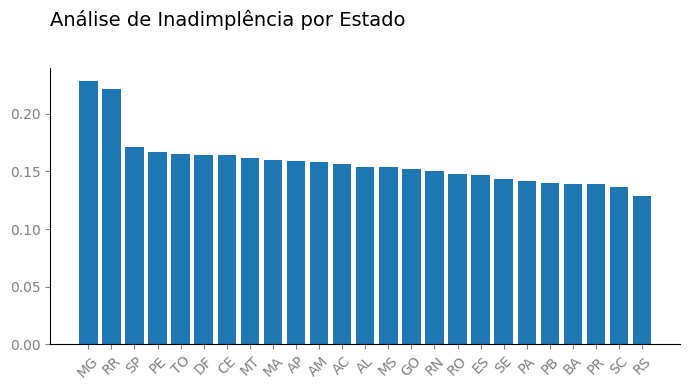

In [16]:
fig, ax = plt.subplots(figsize=(7,4))
agrupado_estado = df_clean.groupby('shipping_state').target_default.mean().sort_values(ascending=False)

ax.bar(agrupado_estado.index, agrupado_estado)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(agrupado_estado.index, rotation=45)
ax.tick_params(colors='grey')
ax.set_title('Análise de Inadimplência por Estado', loc='left', fontsize=14, pad=30)
plt.tight_layout()



Nota-se que os estados de MG e RR se destacam, exercendo maior influência sobre a variável alvo.

Vamos agora realizar a mesma análise para coluna `application_time_applied`, que agora representa a apenas a hora da aplicação. 

A coluna `application_time_applied` representa algo como a hora da aplicação. Da forma como está é difícil retirar qualquer *insight*, por isso vamos excluir os valores dos minutos e segundos, possibilitando a análise do impacto de cada hora de aplicação sobre a variável alvo.

In [17]:
# excluindo valores de minutos e segundos
df_clean['application_time_applied'] = df_clean['application_time_applied'].str[:2].astype(int)
df_clean.loc[df_clean['application_time_applied'] == 24, 'application_time_applied'] = 0

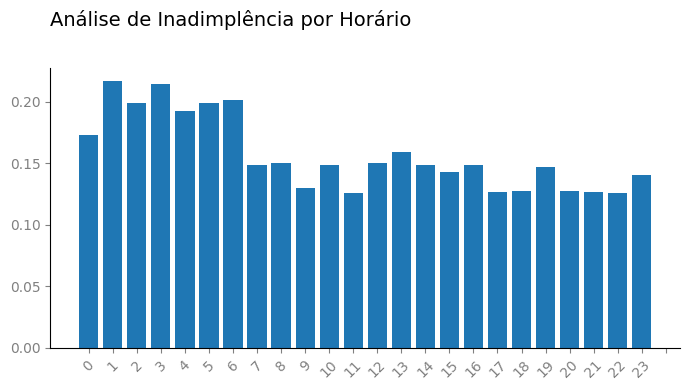

In [18]:
#plotando os gráfico analisando inadimplências por horário os horários
fig, ax = plt.subplots(figsize=(7,4))
hora_agrupada = df_clean.groupby('application_time_applied').target_default.mean().sort_index()

ax.bar(hora_agrupada.index, hora_agrupada)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(hora_agrupada.index, rotation=45)
ax.set_xticks(range(0, 25))
ax.tick_params(colors='grey')
ax.set_title('Análise de Inadimplência por Horário', loc='left', fontsize=14, pad=30)

plt.tight_layout()

Percebe-se que aplicações realizadas antes das sete horas da manhã têm maior probabilidade de inadimplência. Para melhor utilizar essa informação, vamos criar a coluna `overnight` com valores 0 e 1, sendo 1 para aplicações feitas de madrugada e 0 para demais horários

In [19]:
df_clean['overnight'] = df_clean['application_time_applied'].apply(lambda x: 1 if x <= 6 else 0)
df_clean.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,marketing_channel,reported_income,shipping_state,overnight
0,0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,Sim,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,18.0,18.0,7,444,outlook.com,2,0.0,51.0,645,Invite-email,57849.0,MT,0
1,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,Não,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,2,346,gmail.com,1,0.0,17.0,243,Radio-commercial,4902.0,RS,1
2,1,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,25213.0,65023.65,Não,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,10.0,10.0,0,6,gmail.com,2,1.0,9.0,65,Waiting-list,163679.0,RR,1
3,0,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,Não,n+xK9CfX0bCn77lClTWviw==,1.0,0.0,19.0,19.0,11,406,spgov.com,3,1.0,38.0,815,Waiting-list,1086.0,RN,0
4,0,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,25213.0,60011.29,Sim,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,11.0,10.0,13,240,gmail.com,2,1.0,46.0,320,Invite-email,198618.0,MT,0


Continuando nossa análise exploratória vamos dividir nossas análises, segregando as features do tipo `int` e `float` das features do tipo `object`, analisando separadamente as variáveis numéricas e categóricas do nosso dataset. 

## Análise das features tipo `int` e `float`


In [20]:
# criando nosso dataset com features numéricas
num = df_clean.select_dtypes(include=['int', 'float']).columns
df_num = df_clean[num]
df_num.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,overnight
0,0,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,0.0,0.0,18.0,18.0,7,444,2,0.0,51.0,645,57849.0,0
1,0,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,0.0,0.0,14.0,14.0,2,346,1,0.0,17.0,243,4902.0,1
2,1,360.0,100.027073,0.351918,112.892453,0.29,25213.0,65023.65,0.0,0.0,10.0,10.0,0,6,2,1.0,9.0,65,163679.0,1
3,0,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,1.0,0.0,19.0,19.0,11,406,3,1.0,38.0,815,1086.0,0
4,0,500.0,98.474289,0.532539,118.126207,0.18,25213.0,60011.29,0.0,0.0,11.0,10.0,13,240,2,1.0,46.0,320,198618.0,0


Uma vez segregado nosso dataset vamos verificar os dados únicos por coluna para checar distribuição.

In [21]:
# verificando os dados por coluna para checar distribuição
for column in df_num.columns:
  print(f'Coluna {column}: {df_num[column].unique()}')
  print('------------'*10)

Coluna target_default: [0 1]
------------------------------------------------------------------------------------------------------------------------
Coluna score_3: [350. 370. 360. 510. 500. 300. 250. 330. 390. 340. 460. 400. 310. 190.
 210. 590. 280. 260. 320. 420. 450. 240. 430. 530. 470. 270. 290. 570.
 180. 220. 620. 520. 560. 490. 200. 440. 230. 480. 410. 170. 160. 140.
 780. 380. 540. 550. 650.  80. 150. 580. 100. 690. 630. 640. 110. 600.
 120. 130. 670. 610. 730. 660.  70. 680. 760. 700. 720. 820.  90. 710.
  50.  30.  20. 750.  60. 810. 790. 770.  40. 740. 840. 910. 860. 990.
 880. 850.   0.]
------------------------------------------------------------------------------------------------------------------------
Coluna score_4: [101.80083171  97.06261531 100.02707252 ... 102.37778011 100.47609005
 101.09581302]
------------------------------------------------------------------------------------------------------------------------
Coluna score_5: [0.25955467 0.94265452 0.3519176

Abaixo vamos realizar algumas análises de correlações entre as features numéricas e nossa feature alvo, através de *scatter plots*.

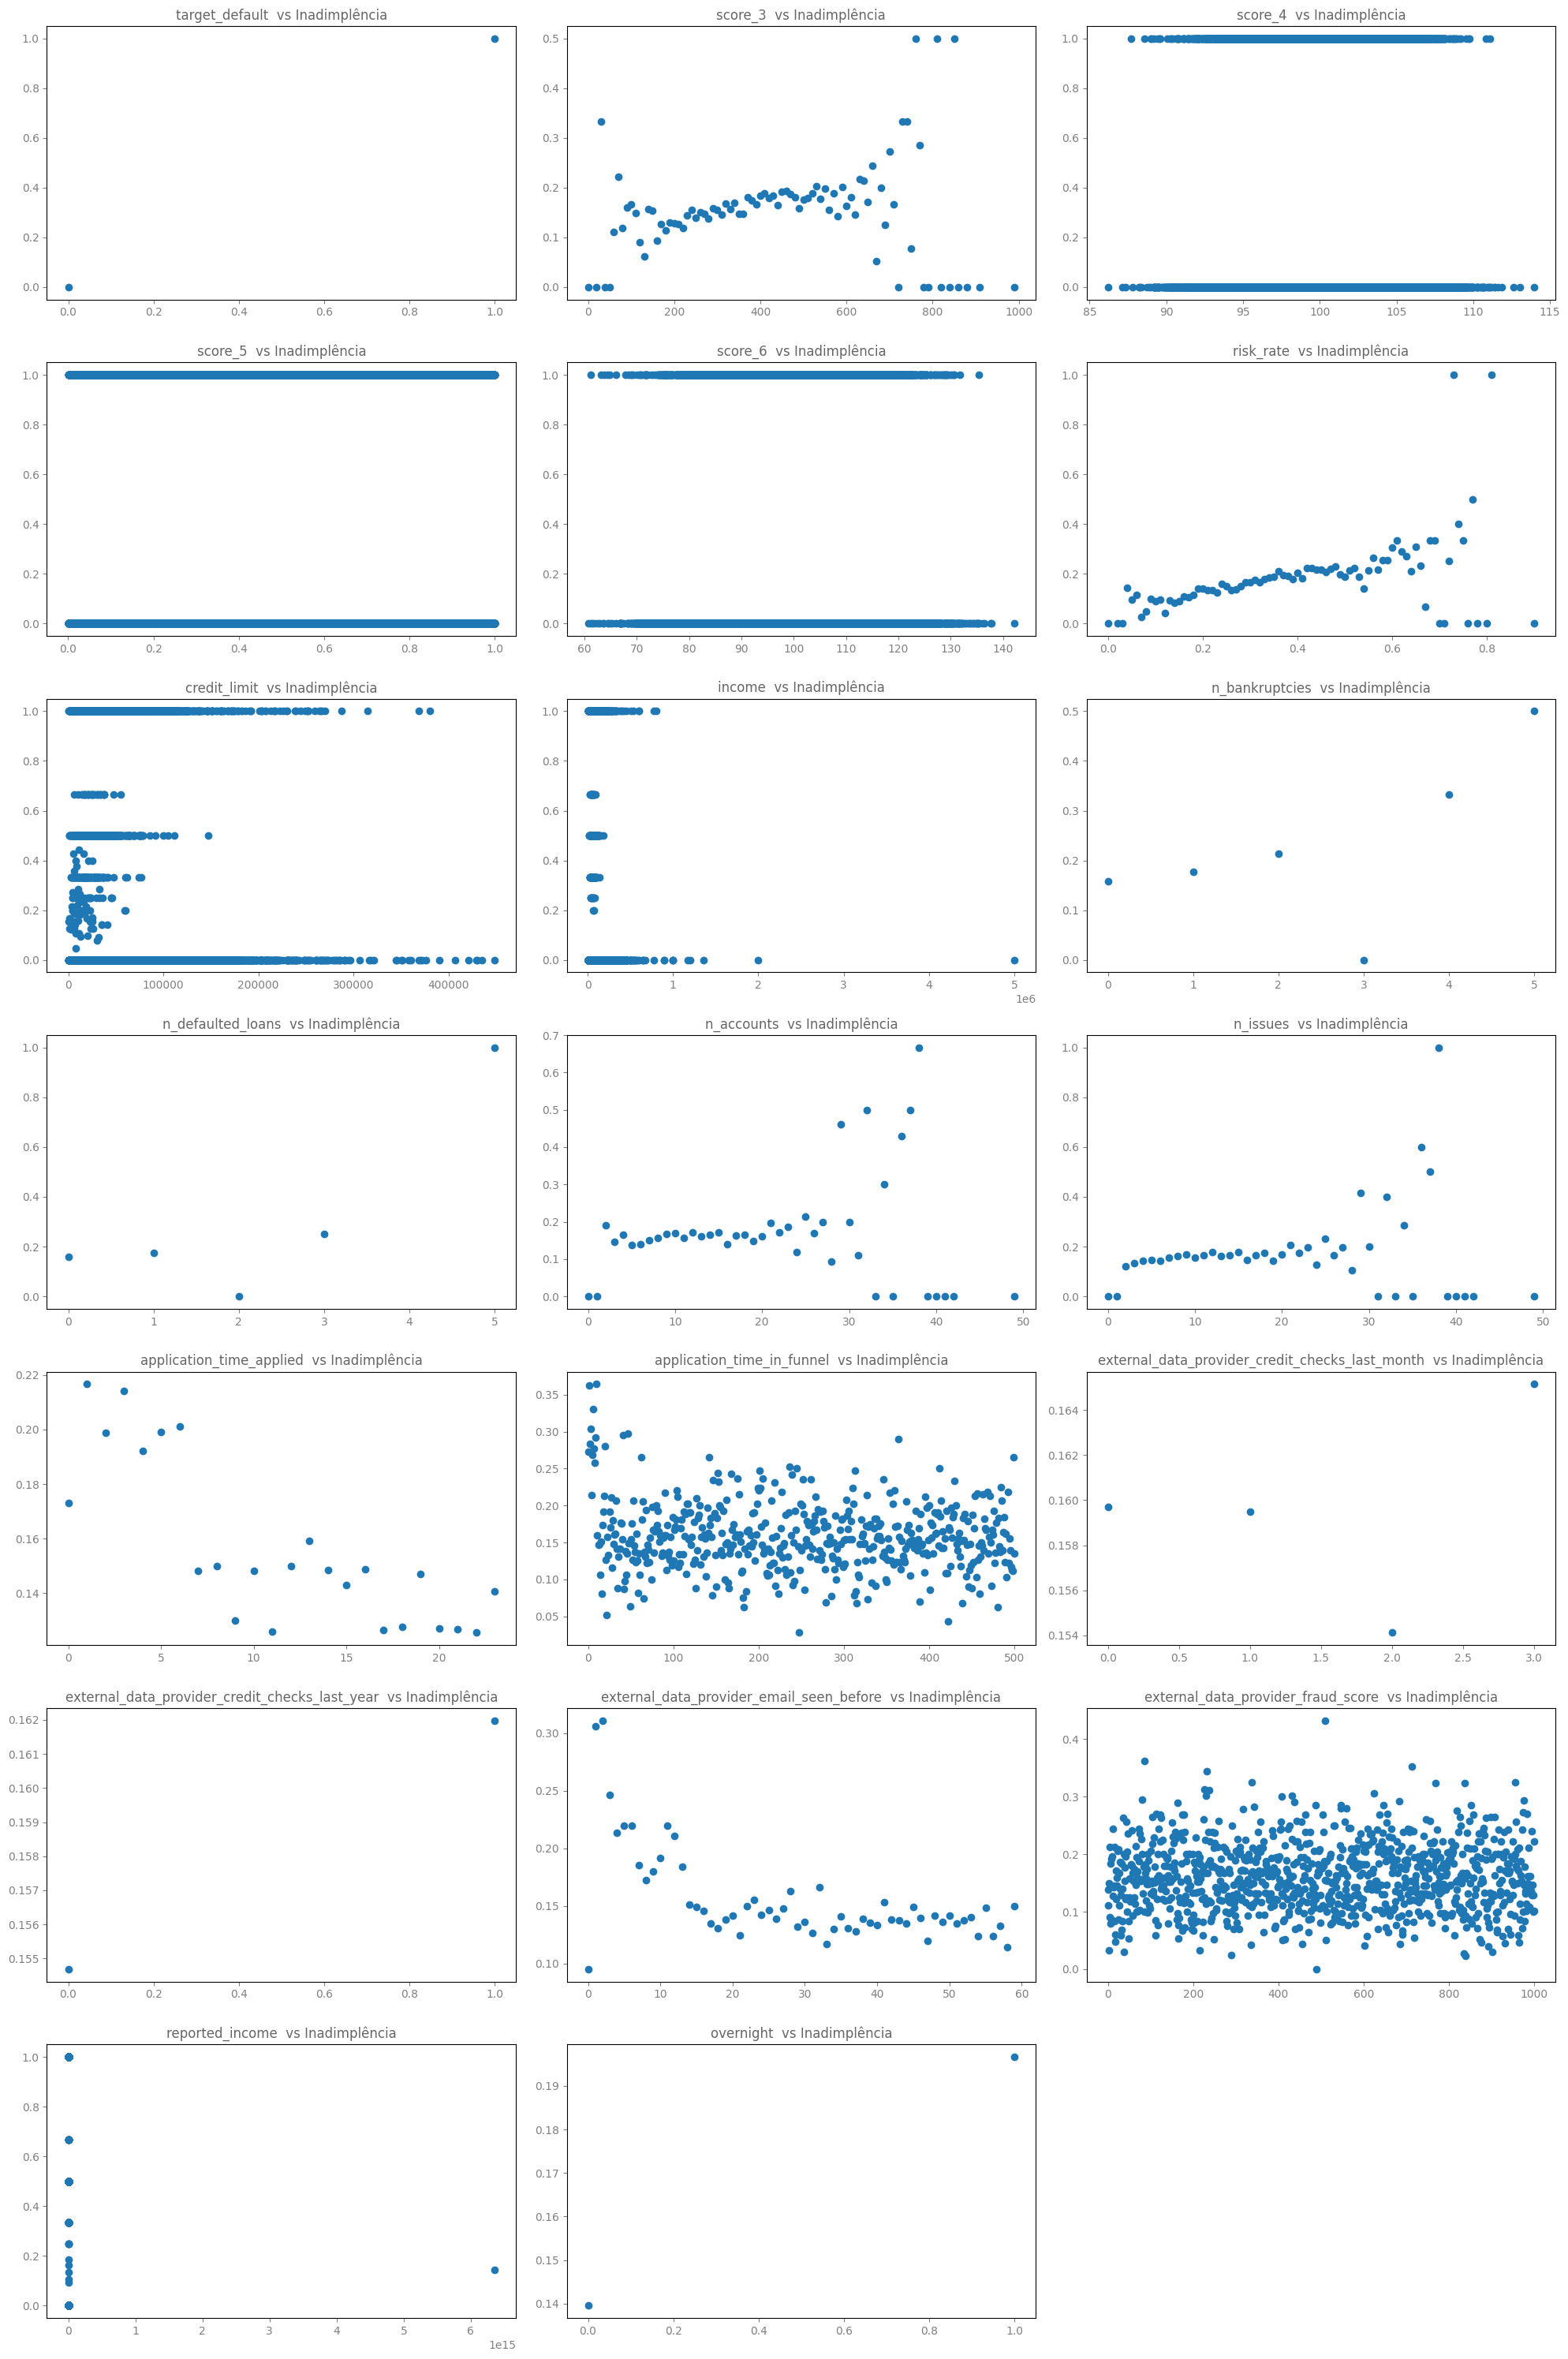

In [22]:
list_num = [x for x in num]
fig = plt.figure(figsize=(20,30))

for i in range(len(list_num)):
  num_plot = df_clean.groupby(list_num[i]).target_default.mean()
  ax = fig.add_subplot(7, 3, i+1)
  ax.scatter(num_plot.index, num_plot)
  ax.set_title(f'{list_num[i]}  vs Inadimplência', alpha=0.6)
  ax.tick_params(colors='grey')

plt.tight_layout();

Podemos destacar que:
* Valores mais altos na coluna `n_bankruptcies` implicam em maior chance de inadimplência. Isso faz sentido, uma vez que esta coluna representa algo como “número de falências”;
* Valores mais altos na coluna `external_data_provider_email_seen_before` implicam em menor chance de inadimplência;
* Não é possível afirma muito a respeito dos outros gráficos.
* Valores menores em `application_time_applied` implicam em maiores valores de inadimplência, o que já foi analisado anteriormente, no gráficos das horas registradas.

## Análise das features tipo `object`


In [23]:
# segregando as variáveis do tipo objeto do nosso dataframe
obj = df_clean.select_dtypes(include=['object']).columns
df_obj = df_clean[obj]
df_obj.head()

,score_1,score_2,facebook_profile,real_state,email,marketing_channel,shipping_state
0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,Sim,N5/CE7lSkAfB04hVFFwllw==,outlook.com,Invite-email,MT
1,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,Não,N5/CE7lSkAfB04hVFFwllw==,gmail.com,Radio-commercial,RS
2,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,Não,n+xK9CfX0bCn77lClTWviw==,gmail.com,Waiting-list,RR
3,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,Não,n+xK9CfX0bCn77lClTWviw==,spgov.com,Waiting-list,RN
4,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,Sim,n+xK9CfX0bCn77lClTWviw==,gmail.com,Invite-email,MT


Agora vamos verificar os dados únicos por feature do nosso dataset.

In [24]:
# iterando pelos dados únicos em nosso dataframe com features do tipo object
for column in df_obj.columns:
  print(f'Coluna {column}: {df_obj[column].unique()}')
  print('------------'*10)

Coluna score_1: ['1Rk8w4Ucd5yR3KcqZzLdow==' 'DGCQep2AE5QRkNCshIAlFQ=='
 '8k8UDR4Yx0qasAjkGrUZLw==' '4DLlLW62jReXaqbPaHp1vQ=='
 'e4NYDor1NOw6XKGE60AWFw==' 'smzX0nxh5QlePvtVf6EAeg=='
 'fyrlulOiZ+5hoFqLa6UbDQ==']
------------------------------------------------------------------------------------------------------------------------
Coluna score_2: ['IOVu8au3ISbo6+zmfnYwMg==' 'SaamrHMo23l/3TwXOWgVzw=='
 'Fv28Bz0YRTVAT5kl1bAV6g==' 'dCm9hFKfdRm7ej3jW+gyxw=='
 '+CxEO4w7jv3QPI/BQbyqAA==' 'tQUTfUyeuGkhRotd+6WjVg=='
 'cdpgyOyZS04uXerMNu7uCw==' '/tdlnWjXoZ3OjdtBXzdOJQ=='
 'YLGMUI9hObSh6wD/xfanGg==' 'O4i7FxcROACMVTCgI0WXuA=='
 'osCzpM4hJrxugqWWuZmMWw==' 'RO7MTL+j4PH2gNzbhNTq/A=='
 '7h8PTkrlTWUPP3yuyP4rUg==' '7h+tk4z7O9brtBSe1rNjxA=='
 'LCak332j+TYFqHC3NDwiqg==' 'OlDYtdljgSSYM/M1L2CRaQ=='
 'dWJRASUFMejk3AHZ1p1Gkg==' 'pAzpxkhjPsjWldgSX21+zg=='
 'wkeCdGeu5sEv4/fjwR0aDg==' 'd/7Hedyz7ovK9Pn1CYN4+A=='
 'w1miZqhB5+RSamEQJa0rqg==' 'rJZgTmANW3PjOCQLCcp4iQ=='
 'ky19q4V1ZqgL3jnHX0wKDw==' 'vJyc9xom9v7hwFMPTIp

Após analisarmos os dados únicos de cada variável do tipo 'object' identificamos que as features `marketing_channel`, `email`, `facebook_profile` e `shipping_state` apresentam dados a serem analisados. As demais colunas possuem dados codificados ou que não são relevantes em nossa análise.



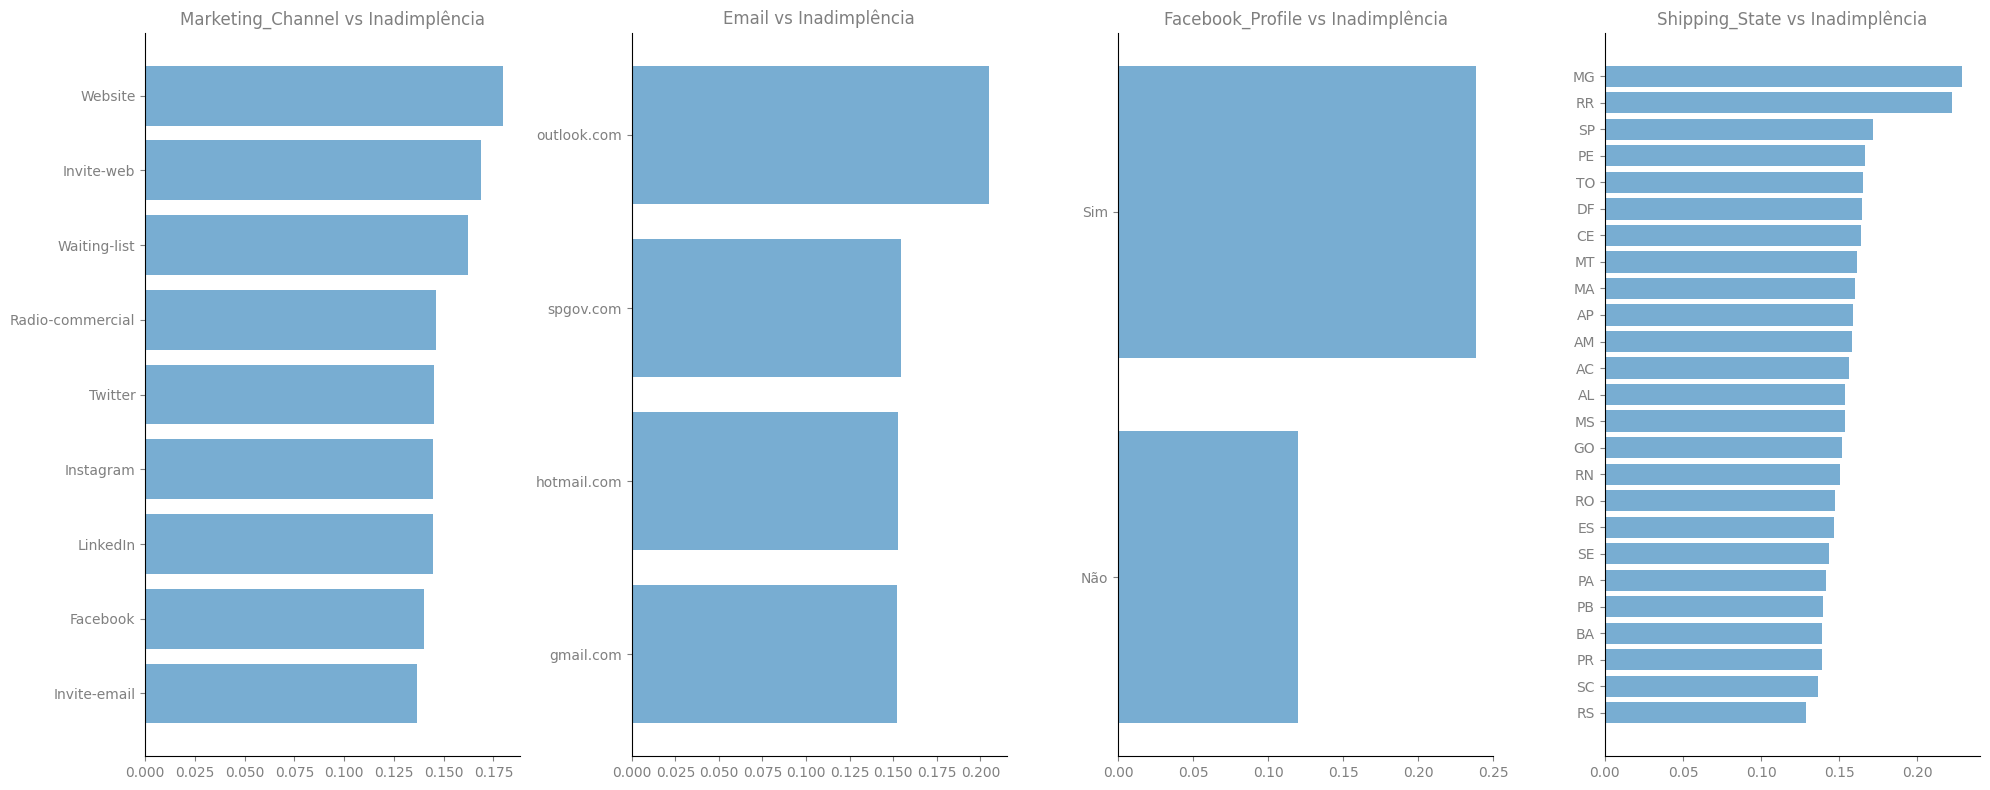

In [25]:
categorical = ['marketing_channel', 'email', 'facebook_profile', 'shipping_state']

fig = plt.figure(figsize=(20,8))

for i in range(len(categorical)):
  to_plot = df_clean.groupby(categorical[i]).target_default.mean().sort_values()
  ax = fig.add_subplot(1, 4, i+1)
  ax.barh(to_plot.index, to_plot, alpha=0.6)
  ax.grid(False)
  ax.tick_params(labelleft=True)
  ax.tick_params(colors='grey')
  ax.set_title(f'{categorical[i].title()} vs Inadimplência', alpha=0.5)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

plt.tight_layout();
plt.show()  

Após o plot acima, podemos observar que:
* E-mails `@outlook.com` tem maior probabilidade de inadimplência;
* Aplicações com perfil no Facebook têm maior chance de inadimplência;
* Não se pode afirmar muito sobre a coluna `marketing_channel`.

Agora vamos usar a classe `LabelEncoder` para transformar variáveis categóricas em forma de texto aleatório como `score_1` e `score_2` (veja acima) em números, para facilitar a visualização.  

Em seguida, essas variáveis serão agrupadas com as demais variáveis categorias e todas elas serão transformadas em *dummies* através da função `get_dummies` do `pandas`. A exceção é a variável `facebook_profile`, que não passará pela segunda etapa, uma vez que, após passar pelo `LabelEncoder` já contará apenas com 0 e 1.

In [26]:
df_clean.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,marketing_channel,reported_income,shipping_state,overnight
0,0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,Sim,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,18.0,18.0,7,444,outlook.com,2,0.0,51.0,645,Invite-email,57849.0,MT,0
1,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,Não,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,2,346,gmail.com,1,0.0,17.0,243,Radio-commercial,4902.0,RS,1
2,1,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,25213.0,65023.65,Não,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,10.0,10.0,0,6,gmail.com,2,1.0,9.0,65,Waiting-list,163679.0,RR,1
3,0,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,Não,n+xK9CfX0bCn77lClTWviw==,1.0,0.0,19.0,19.0,11,406,spgov.com,3,1.0,38.0,815,Waiting-list,1086.0,RN,0
4,0,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,25213.0,60011.29,Sim,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,11.0,10.0,13,240,gmail.com,2,1.0,46.0,320,Invite-email,198618.0,MT,0


In [27]:
cols_encode = ['score_1', 'score_2', 'facebook_profile', 'real_state']

for col in cols_encode:
  encoder = LabelEncoder().fit(df_clean[col])
  df_clean[col] = encoder.transform(df_clean[col])

col_dummies = cols_encode + ['application_time_applied', 'email', 'marketing_channel', 'shipping_state']
col_dummies.remove('facebook_profile')

df_clean = pd.get_dummies(df_clean, columns=col_dummies)

df_clean.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,overnight,score_1_0,score_1_1,score_1_2,score_1_3,score_1_4,score_1_5,score_1_6,score_2_0,score_2_1,score_2_2,score_2_3,score_2_4,score_2_5,score_2_6,score_2_7,score_2_8,score_2_9,score_2_10,score_2_11,score_2_12,score_2_13,score_2_14,score_2_15,score_2_16,score_2_17,score_2_18,score_2_19,score_2_20,score_2_21,score_2_22,score_2_23,score_2_24,score_2_25,score_2_26,score_2_27,score_2_28,score_2_29,score_2_30,score_2_31,score_2_32,score_2_33,score_2_34,real_state_0,real_state_1,real_state_2,real_state_3,real_state_4,application_time_applied_0,application_time_applied_1,application_time_applied_2,application_time_applied_3,application_time_applied_4,application_time_applied_5,application_time_applied_6,application_time_applied_7,application_time_applied_8,application_time_applied_9,application_time_applied_10,application_time_applied_11,application_time_applied_12,application_time_applied_13,application_time_applied_14,application_time_applied_15,application_time_applied_16,application_time_applied_17,application_time_applied_18,application_time_applied_19,application_time_applied_20,application_time_applied_21,application_time_applied_22,application_time_applied_23,email_gmail.com,email_hotmail.com,email_outlook.com,email_spgov.com,marketing_channel_Facebook,marketing_channel_Instagram,marketing_channel_Invite-email,marketing_channel_Invite-web,marketing_channel_LinkedIn,marketing_channel_Radio-commercial,marketing_channel_Twitter,marketing_channel_Waiting-list,marketing_channel_Website,shipping_state_AC,shipping_state_AL,shipping_state_AM,shipping_state_AP,shipping_state_BA,shipping_state_CE,shipping_state_DF,shipping_state_ES,shipping_state_GO,shipping_state_MA,shipping_state_MG,shipping_state_MS,shipping_state_MT,shipping_state_PA,shipping_state_PB,shipping_state_PE,shipping_state_PR,shipping_state_RN,shipping_state_RO,shipping_state_RR,shipping_state_RS,shipping_state_SC,shipping_state_SE,shipping_state_SP,shipping_state_TO
0,0,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,1,0.0,0.0,18.0,18.0,444,2,0.0,51.0,645,57849.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,0,0.0,0.0,14.0,14.0,346,1,0.0,17.0,243,4902.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,360.0,100.027073,0.351918,112.892453,0.29,25213.0,65023.65,0,0.0,0.0,10.0,10.0,6,2,1.0,9.0,65,163679.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,0,1.0,0.0,19.0,19.0,406,3,1.0,38.0,815,1086.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,500.0,98.474289,0.532539,118.126207,0.18,25213.0,60011.29,1,0.0,0.0,11.0,10.0,240,2,1.0,46.0,320,198618.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


O próximo passo será dividir o `dataset` em treino e teste, padronizar os dados utilizando a classe `StandardScaler`. Após realizarmos este processo com o *dataset* original, vamos usar a função `resample` para criar um *dataset* balanceado e repetir, neste novo *dataset*, o mesmo processo de divisão e padronização dos dados. Em seguida, vamos verificar o balanceamento.

In [28]:
print(df_clean['target_default'].value_counts(), '\n')

0    35080
1     6661
Name: target_default, dtype: int64 



In [29]:
# Dividindo e padronizando o dataset original
X = df_clean.drop('target_default', axis=1)
y = df_clean['target_default']

X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_unb = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Criando o dataset balanceado
maioria = df_clean[df_clean['target_default'] == 0]
minoria = df_clean[df_clean['target_default'] == 1]

minoria_balanceada = resample(minoria, replace=True, n_samples=35080)

df_balanceado = pd.concat([maioria, minoria_balanceada])

# Dividindo e padronizando o dataset balanceado
X_balanceado = df_balanceado.drop('target_default', axis=1)
y_balanceado = df_balanceado['target_default']

X_train_balanceado, X_test_balanceado, y_train_balanceado, y_test_balanceado = train_test_split(X_balanceado, y_balanceado)

scaler_balanceado = StandardScaler()
scaler_balanceado.fit(X_train_balanceado)
X_train_balanceado = scaler_balanceado.transform(X_train_balanceado)
X_test_balanceado = scaler_balanceado.transform(X_test_balanceado)

# Verificando o balanceamento
print(df_balanceado['target_default'].value_counts(), '\n')

# fig, ax = plt.subplots(figsize=(8,6))
# sns.countplot(df_balanceado['target_default'])
# ax.set_title('Dados após o balnaceamento')
# plt.show()

0    35080
1    35080
Name: target_default, dtype: int64 



# 4 - Modelos de Machine Learning

Vamos usar quatro algoritmos diferentes para treinar modelos:
* [Regressão Logística](https://pt.wikipedia.org/wiki/Regress%C3%A3o_log%C3%ADstica);
* [Árvores de Decisão](https://medium.com/machine-learning-beyond-deep-learning/%C3%A1rvores-de-decis%C3%A3o-3f52f6420b69);
* [Random Forest](https://en.wikipedia.org/wiki/Random_forest);
* [XGBoost](https://pt.wikipedia.org/wiki/Xgboost).

Usando a técnica de [validação cruzada](https://pt.wikipedia.org/wiki/Valida%C3%A7%C3%A3o_cruzada#:~:text=A%20valida%C3%A7%C3%A3o%20cruzada%20%C3%A9%20uma,da%20modelagem%20%C3%A9%20a%20predi%C3%A7%C3%A3o.), vamos ver o desempenho desses quatro algoritmos tanto com os dados balanceados, como com os dados desbalanceados e, portando, teremos oito modelos.
Usaremos as seguintes [métricas](https://www.mariofilho.com/as-metricas-mais-populares-para-avaliar-modelos-de-machine-learning/) para avaliar os modelos:

* Acurácia;
* Precisão;
* Recall;
* Área sob a curva ROC.

Em seguida, vamos gerar um DataFrame com os resultados de cada um dos modelos para facilitar a visualização e a escolha do melhor modelo.

In [30]:
# Criando os modelos utilizando validação cruzada
logreg_balanceado  = cross_validate(LogisticRegression(solver='liblinear'), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
logreg = cross_validate(LogisticRegression(solver='liblinear'), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

trees_balanceado  = cross_validate(DecisionTreeClassifier(), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
trees = cross_validate(DecisionTreeClassifier(), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

forest_balanceado  = cross_validate(RandomForestClassifier(), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
forest = cross_validate(RandomForestClassifier(), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

xgb_balanceado  = cross_validate(XGBClassifier(), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
xgb = cross_validate(XGBClassifier(), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

# Gerando um DataFrame com os resultados de cada modelo
summary = pd.DataFrame({
            'labels': ['accuracy', 'precision', 'recall', 'roc_auc'],
            'logreg_balanceado': [logreg_balanceado['test_accuracy'].mean(), logreg_balanceado['test_precision'].mean(), logreg_balanceado['test_recall'].mean(), logreg_balanceado['test_roc_auc'].mean()],
            'logreg': [logreg['test_accuracy'].mean(), logreg['test_precision'].mean(), logreg['test_recall'].mean(), logreg['test_roc_auc'].mean()],
            'trees_balanceado': [trees_balanceado['test_accuracy'].mean(), trees_balanceado['test_precision'].mean(), trees_balanceado['test_recall'].mean(), trees_balanceado['test_roc_auc'].mean()],
            'trees': [trees['test_accuracy'].mean(), trees['test_precision'].mean(), trees['test_recall'].mean(), trees['test_roc_auc'].mean()],
            'forest_balanceado': [forest_balanceado['test_accuracy'].mean(), forest_balanceado['test_precision'].mean(), forest_balanceado['test_recall'].mean(), forest_balanceado['test_roc_auc'].mean()],
            'forest': [forest['test_accuracy'].mean(), forest['test_precision'].mean(), forest['test_recall'].mean(), forest['test_roc_auc'].mean()],
            'xgb_balanceado': [xgb_balanceado['test_accuracy'].mean(), xgb_balanceado['test_precision'].mean(), xgb_balanceado['test_recall'].mean(), xgb_balanceado['test_roc_auc'].mean()],
            'xgb': [xgb['test_accuracy'].mean(), xgb['test_precision'].mean(), xgb['test_recall'].mean(), xgb['test_roc_auc'].mean()]           
}).set_index('labels')
summary.index.name=None
summary = summary.transpose()    
summary.style.applymap(lambda x: 'background-color: lightgreen' if x >= 0.75 else '')

,accuracy,precision,recall,roc_auc
logreg_balanceado,0.662030,0.661039,0.666312,0.720304
logreg,0.840537,0.000000,0.000000,0.500450
trees_balanceado,0.876188,0.816174,0.971405,0.876104
trees,0.746175,0.231796,0.255409,0.547345
forest_balanceado,0.956100,0.946374,0.967075,0.987377
forest,0.841303,0.565608,0.021033,0.699702
xgb_balanceado,0.796883,0.777237,0.832833,0.876809
xgb,0.836001,0.439722,0.103364,0.686864


De uma forma geral, os dados balanceados apresentaram melhores resultados considerando as quatro métricas utilizadas. Dentre os algoritmos, *Random Forests* apresentou os melhores resultados e, portanto, a combinação desse modelo com os dados balanceados é a escolhida para o projeto.

### ***Tunning* de Hiperparâmetros**

Para realizar um ajuste fino no modelo, nas próximas células de código vamos utilizar a técnica de [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para escolher o melhor valor para os seguintes hiperparâmetros:

* *criterion*;
* *n_estimators*;
* *max_depth*;
* *min_samples_split*;
* min_samples_leaf.


In [31]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

forest = RandomForestClassifier()

param_grid = {'criterion': ['gini', 'entropy']}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.9877630025735586 para {'criterion': 'gini'}


In [32]:
forest = RandomForestClassifier(criterion='gini')

param_grid = {'n_estimators': range(400, 500, 50)}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.9885141416114885 para {'n_estimators': 400}


In [33]:
forest = RandomForestClassifier(criterion='gini', n_estimators=400)

param_grid = {'max_depth': range(7, 10)}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.7627765058997411 para {'max_depth': 9}


In [34]:
forest = RandomForestClassifier(criterion='gini', n_estimators=400)

param_grid = {'min_samples_split': range(2, 4, 2)}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.9882890274529516 para {'min_samples_split': 2}


In [35]:
forest = RandomForestClassifier(criterion='gini', n_estimators=400, min_samples_split=2)

param_grid = {'min_samples_leaf': range(1, 2, 1)}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.988161130150323 para {'min_samples_leaf': 1}


# 5 - Avaliação final do modelo

Nessa fase, é preciso avaliar os resultados e levantar todas as possibilidades de variações que os dados possam ter, analisando se existe algum fator que tenha sido negligenciado e até que ponto o modelo atende aos objetivos do negócio. Devemos sumarizar os resultados em termos de critérios de sucesso definidos no início do projeto. O resultado do modelo deve ser satisfatório tecnicamente e para as necessidades do negócio.

Agora que já exploramos e preparamos os dados, instaciamos o modelo e fizemos previsões no conjunto de validação, é hora de descobrirmos o potencial do nosso modelo com os dados de teste. Lembrando que nossa base de testes não pode ter os dados balanceados pois haveria perda. Nosso modelo precisa ser tratado mas precisamos fazer previsões em todas as linhas que ele receber. Os dados que foram padronizados devem permanecer dessa forma.

Com os hiperparâmetros ajustados, vamos agora avaliar o modelo com os dados de teste.

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      8793
           1       0.97      0.98      0.97      8747

    accuracy                           0.97     17540
   macro avg       0.97      0.97      0.97     17540
weighted avg       0.97      0.97      0.97     17540

ROC_AUC Score: 0.9743678035878 

Recall:		0.9833
Acurácia:	0.9743
Precisão:	0.9659
F1-Score:	0.9743


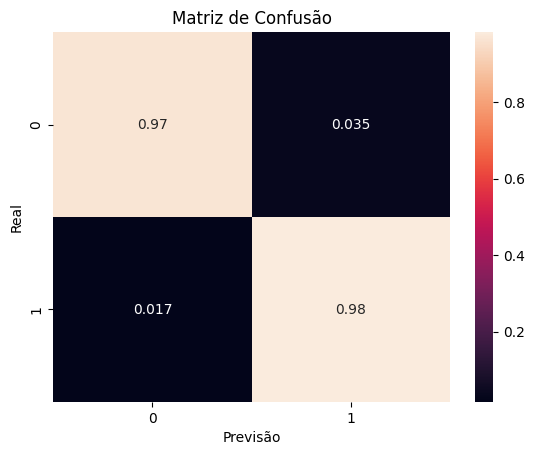

In [49]:
modelo = RandomForestClassifier(criterion='gini', n_estimators=400, min_samples_split=2, min_samples_leaf=1)
modelo.fit(X_train_balanceado, y_train_balanceado)

y_pred = modelo.predict(X_test_balanceado)

print(classification_report(y_test_balanceado, y_pred))
print(f'ROC_AUC Score: {roc_auc_score(y_test_balanceado, y_pred)}', '\n')
print(f'Recall:\t\t{recall_score(y_test_balanceado, y_pred, pos_label=1):0.4f}')
print(f'Acurácia:\t{accuracy_score(y_test_balanceado, y_pred):0.4f}')
print(f'Precisão:\t{precision_score(y_test_balanceado, y_pred, zero_division=0):0.4f}')
print(f'F1-Score:\t{f1_score(y_test_balanceado, y_pred, average="micro"):0.4f}')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test_balanceado, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

O modelo de Random Forest apresentou uma métrica Recall de 0.9832, Acurácia de 0.9754 e Precisão de 0.9680. A área sob a curva apresentada é de 0.9754 e F1-score de 0.9754.

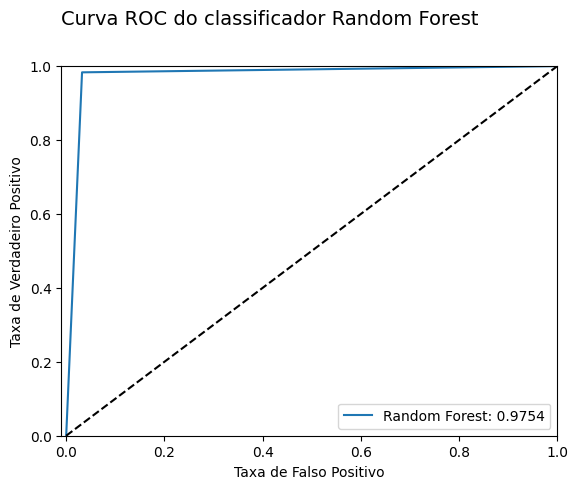

In [46]:
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test_balanceado, y_pred)

plt.figure()
plt.title('Curva ROC do classificador Random Forest', loc='left', fontsize=14, pad=30)
plt.plot(rf_fpr, rf_tpr, label='Random Forest: {:.4f}'.format(roc_auc_score(y_test_balanceado, y_pred)))
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend()
plt.show()


A curva ROC (Receiver Operating Characteristic) e a métrica AUC (Area Under the Curve) são comumente usadas para avaliar o desempenho de modelos de classificação em machine learning. A interpretação dessas métricas está relacionada à capacidade do modelo de distinguir entre classes positivas e negativas.

Em resumo, um gráfico ROC-AUC bem-sucedido mostra uma curva que se aproxima do canto superior esquerdo do gráfico, indicando uma alta taxa de verdadeiros positivos e uma baixa taxa de falsos positivos em diferentes limiares de classificação. Isso sugere um bom desempenho do modelo na tarefa de classificação.

O nosso gráfico acima evidencia exatamente isto, com uma métrica de 0,9754, o que é um ótimo resultado para o nosso modelo.

# Conclusão
Neste projeto, nosso foco foi a identificação de risco de crédito. O objetivo principal foi construir um modelo de aprendizado de máquina capaz de reconhecer possíveis inadimplentes. Para isso, realizarmos todos os procedimentos de limpeza dos dados, padronização, balanceamento, comparabilidade de modelos baselines e ajustes de hiperparâmetros.

Como resultado de nosso esforço, além de obter insights valiosos sobre a influência das características na variável alvo, conseguimos construir um modelo preditivo altamente eficiente. Esse modelo demonstrou uma taxa de acurácia impressionante de 98%, o que é um resultado extremamente satisfatório e cumpriu com êxito nosso objetivo inicial.